In [1]:
import warnings
from pathlib import Path
import joblib
import string

import nltk
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=DeprecationWarning)
    # Hides two warnings:
    # 1.
    # sklearn\externals\six.py:31: DeprecationWarning: The module is 
    # deprecated in version 0.21 and will be removed in version 0.23
    # 2.
    # sklearn\externals\joblib\__init__.py:15: DeprecationWarning: 
    # sklearn.externals.joblib is deprecated in 0.21 
    # and will be removed in 0.23. 
    import mglearn  
    
# Paths for files
ROOT_FOLDERPATH = Path.cwd().parent.parent
DATASET_FOLDERPATH = ROOT_FOLDERPATH / 'data' / 'raw'
NEG_DATASET_FILEPATH = DATASET_FOLDERPATH / 'rt-polarity.neg'
POS_DATASET_FILEPATH = DATASET_FOLDERPATH / 'rt-polarity.pos'
MODEL_FILEPATH = ROOT_FOLDERPATH / 'model' / 'poc-02--n-gram--logistic-regression.joblib'

# Data labels
POS = 1
NEG = 0
LABEL_NAMES = {
    POS: "Positive",
    NEG: "Negative"
}

# Magic values
RANDOMNESS_SEED = 834
DATASET_TEST_SPLIT_RATIO = 0.2

# Data preprocessing and Feature Extraction

##### Load the dataset to memory

In [3]:
with NEG_DATASET_FILEPATH.open() as file:
    corpus_neg = file.readlines()
    
with POS_DATASET_FILEPATH.open() as file:
    corpus_pos = file.readlines()

##### Split and shuffle the dataset

In [4]:
corpus = corpus_neg + corpus_pos
labels = [NEG] * len(corpus_neg) + [POS] * len(corpus_pos)
training_corpus, testing_corpus, training_labels, testing_labels = train_test_split(
        corpus, labels, 
        test_size=DATASET_TEST_SPLIT_RATIO, 
        random_state=RANDOMNESS_SEED)

print(f"Training dataset size: {len(training_corpus)}")
print(f"Testing dataset size: {len(testing_corpus)}")

Training dataset size: 8529
Testing dataset size: 2133


##### Clean data and Extract features

In [5]:
nltk.download('stopwords', quiet=True, raise_on_error=True)
stop_words = set(nltk.corpus.stopwords.words('english'))
tokenized_stop_words = nltk.word_tokenize(' '.join(nltk.corpus.stopwords.words('english')))
nltk.download('punkt', quiet=True, raise_on_error=True)
stemmer = nltk.stem.PorterStemmer()

class Tokenizer(object):
    @staticmethod
    def _stem(token):
        # Solves error "UserWarning: Your stop_words may be 
        # inconsistent with your preprocessing."
        if (token in stop_words):
            return token  
        
        return stemmer.stem(token)
        
    def __call__(self, line):
        tokens = nltk.word_tokenize(line)
        # Remove words with non-alphabet characters
        tokens = (token for token in tokens if token.isalpha())  
        tokens = (self._stem(token) for token in tokens)
        return list(tokens)

vectorizer = CountVectorizer(min_df=5, 
                            ngram_range=(1, 2),
                            tokenizer=Tokenizer(),
                            stop_words=tokenized_stop_words,
                            lowercase=True)
vectorizer.fit(training_corpus)
training_input = vectorizer.transform(training_corpus)
testing_input = vectorizer.transform(testing_corpus)

# Show result
print(repr(training_input))

<8529x3637 sparse matrix of type '<class 'numpy.int64'>'
	with 74499 stored elements in Compressed Sparse Row format>


In [6]:
amount = 10
feature_tokens = vectorizer.get_feature_names()
print(f"First {amount} selected features ({len(feature_tokens)} in total):")
print(*[f"{id+1}. {a}" for id, a in enumerate(feature_tokens[:amount])], sep='\n')

First 10 selected features (3637 in total):
1. abandon
2. abil
3. abl
4. abli
5. absolut
6. absorb
7. abstract
8. absurd
9. absurdist
10. abus


# Training 

### Run the training

##### Train the Naive Bayes Classifier

In [7]:
param_grid = {'C': [0.01, 0.1]}
grid = GridSearchCV(LogisticRegression(solver='lbfgs'), param_grid, cv=5, n_jobs=-1)
grid.fit(training_input, training_labels)
classifier = grid.best_estimator_

# Print initial and selected parameters of training
print(repr(grid))
print("Best cross-validation score: {:.2f}".format(grid.best_score_))
print("Best parameters: ", grid.best_params_)
print("Best estimator: ", grid.best_estimator_)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='warn',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=-1, param_grid={'C': [0.01, 0.1]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)
Best cross-validation score: 0.74
Best parameters:  {'C': 0.1}
Best estimator:  LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1

##### Save the model

In [8]:
with MODEL_FILEPATH.open('wb') as file:
    joblib.dump({
        'classifier': classifier,
        'vectorizer': vectorizer
    }, file)
    print("Saved.")

Saved.


##### Show most informative features

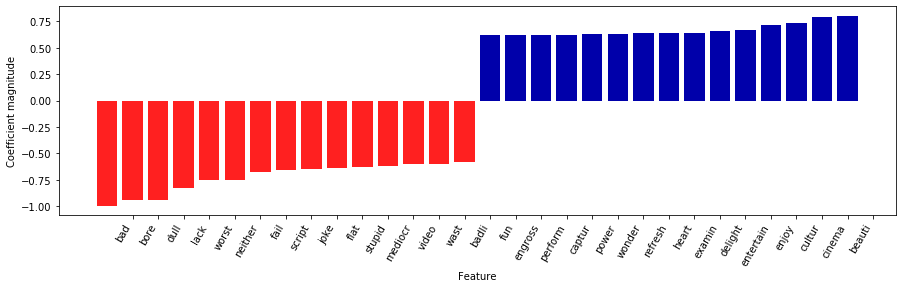

In [9]:
mglearn.tools.visualize_coefficients(grid.best_estimator_.coef_, feature_tokens, n_top_features=15)
plt.show()

# Performance evaluation
##### Test set accuracy

In [10]:
classifier.predict(testing_input)
test_accuracy = classifier.score(testing_input, testing_labels)
print(f"Test set accuracy: {test_accuracy * 100:.2f}%")

Test set accuracy: 72.34%


# Deployment
##### Example prediction

In [11]:
input_text = "This movie was boring..."

def predict(input_text):
    with MODEL_FILEPATH.open('rb') as file_:
        file_contents = joblib.load(file_)
        
    classifier = file_contents['classifier']
    vectorizer = file_contents['vectorizer']
    
    model_input = vectorizer.transform([input_text])
    return classifier.predict(model_input)[0]

print(f'Sentence "{input_text}" is classified as {LABEL_NAMES[predict(input_text)]}')

Sentence "This movie was boring..." is classified as Negative
